In [1]:
pip install transformers datasets evaluate seqeval jsonlines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=67a7d4588d249e212a4c5dcd0a65816f2c918411fc3094b207b7b13a06a8c887
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Attempting uninstall

In [2]:
import jsonlines
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import copy
import spacy
import re
from tqdm import tqdm
import pickle
import random

In [55]:
id2label = {
    0: "O",
    1: "PERSON",
    2: "PERSON",
    3: "ORG",
    4: "ORG",
    5: "LOC",
    6: "LOC",
    7: "MISC",
    8: "MISC"
}

def normalise_data(spans):
  prev_label = -1
  prev_end = -1
  prev_start = -1
  count = 0
  for i in range(len(spans)):
    if prev_label == -1:
      prev_label = spans[i]['label']
      prev_end = spans[i]['end']
      prev_start = spans[i]['start']

    else:
      if prev_label == spans[i]['label'] and prev_end == spans[i]['start'] - 1:
        spans[i]['start'] = prev_start
        del spans[i-1]
        return spans

      else:
        prev_label = spans[i]['label']
        prev_end = spans[i]['end']
        prev_start = spans[i]['start']

  return 1

def conll_to_format(conll_data):
  split_text = conll_data['tokens']
  split_tags = conll_data['ner_tags']

  format_text = []
  format_tags = []

  for i in range(len(split_text)):
    format_text.append(" ".join(split_text[i]))

  for i in range(len(split_tags)):
    format_tags.append([id2label[tag] for tag in split_tags[i]])

  spans = []
  for i in range(len(format_tags)):
    temp = []
    for j in range(len(format_tags[i])):
      if format_tags[i][j] != "O":
        start = format_text[i].find(split_text[i][j])
        end = start + len(split_text[i][j])
        temp.append({"start": start, "end": end, "label": format_tags[i][j]})
    spans.append(temp)

  new_spans = []
  for i in range(len(spans)):
    while(normalise_data(spans[i]) != 1):
      normalise_data(spans[i])

    new_spans.append(spans[i])

  return format_text, new_spans

In [56]:
from datasets import load_dataset
dataset = load_dataset('/content/conll2003.py', 'conll2003')

In [57]:
test = conll_to_format(dataset['test'][:500])
val = conll_to_format(dataset['validation'])
train = conll_to_format(dataset['train'])

In [16]:
with open("/content/conll_train.pkl", 'rb') as file:
    base_train = pickle.load(file)

In [ ]:
# aug1[0] = aug1[0] + train[0]
# aug1[1] = aug1[1] + train[1]

# combined = list(zip(aug1[0], aug1[1]))
# random.shuffle(combined)

# aug1[0], aug1[1] = zip(*combined)
# aug1[0] = list(aug1[0])
# aug1[1] = list(aug1[1])

In [22]:
texts = []
spans = []
for i, j in zip(train[0], train[1]):
  if j == []:
    texts.append(i)
    spans.append(j)

base_train[0] = base_train[0] + texts[:200]
base_train[1] = base_train[1] + spans[:200]

combined = list(zip(base_train[0], base_train[1]))
random.shuffle(combined)

base_train[0], base_train[1] = zip(*combined)
base_train[0] = list(base_train[0])
base_train[1] = list(base_train[1])

In [25]:
def get_label_distribution(spans):
  labels = {}
  for i in spans:
      for j in i:
          labels[j['label']] = labels.get(j['label'], 0) + 1

  labels = dict(sorted(labels.items(), key=lambda item: item[0]))
  plt.bar(labels.keys(), labels.values())
  plt.xticks(rotation = 90)
  plt.title("Distribution of NER Tags")
  plt.show()

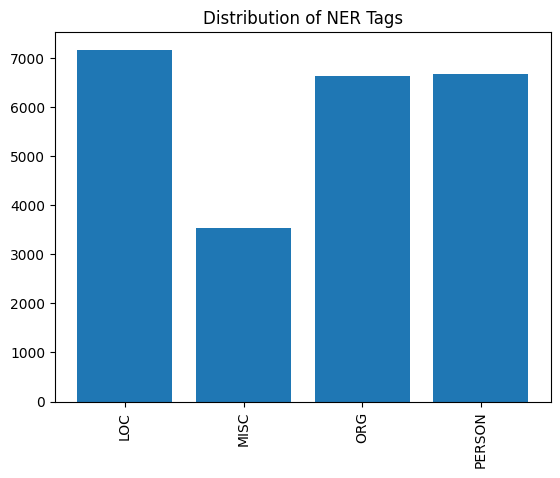

In [26]:
get_label_distribution(train[1])

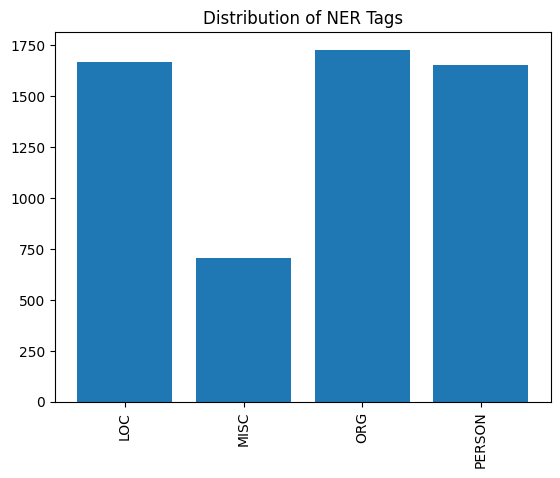

In [27]:
get_label_distribution(test[1])

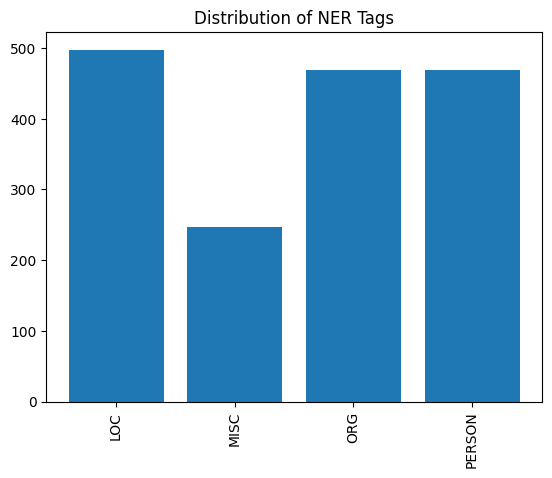

In [29]:
get_label_distribution(base_train[1])

In [30]:
label_list = []
for i in test[1]:
  for j in i:
    if j['label'] not in label_list:
      label_list.append(j['label'])

label_list

['LOC', 'PERSON', 'MISC', 'ORG']

In [58]:
id2label = {
    0: "O",
    1: "PERSON",
    2: "LOC",
    3: "MISC",
    4: "ORG"
}

label2id = {
    "O": 0,
    "PERSON": 1,
    "LOC": 2,
    "MISC": 3,
    "ORG": 4
}

In [32]:
nlp = spacy.load("en_core_web_sm")

token_X = []
tag_y = []
spans = []
texts = []

for i in range(len(base_train[0])):
    doc = nlp(base_train[0][i])
    temp = []
    for j in doc:
        temp.append(str(j))

    flag = True
    tempy = ["O" for k in range(len(temp))]
    for k in base_train[1][i]:
        to_match = base_train[0][k['start']:k['end']]
        span = doc.char_span(k['start'],k['end'])

        try:
          s = span[0].i
          e = span[-1].i
          tag = k['label']

          for l in range(s, e+1):
              tempy[l] = tag
        except:
          flag = False

    if flag:
      token_X.append(temp)
      tag_y.append(tempy)
      spans.append(base_train[1][i])
      texts.append(base_train[0][i])
    else:
      print("Problem at Index {}".format(i))

Problem at Index 157
Problem at Index 464
Problem at Index 505
Problem at Index 866
Problem at Index 924


In [33]:
token_y = []
for i in tag_y:
    temp = []
    for j in i:
        temp.append(label2id[j])
    token_y.append(temp)

In [34]:
def strip(original_string):
    return re.sub(r"\s+", "", original_string)

def count_ws(string, position):
    whitespace_count = 0

    for char in string[:position]:
        if char.isspace():
            whitespace_count += 1

    if position == len(string) or string[position].isspace():
        return position-whitespace_count-1

    return position-whitespace_count

In [35]:
span_without_space = copy.deepcopy(spans)

for i in range(len(spans)):
    sent = texts[i]
    temp = []
    for j in span_without_space[i]:
        s = j['start']
        e = j['end']
        ns = count_ws(texts[i], s)
        ne = count_ws(texts[i], e)
        j['start'] = ns
        j['end'] = ne

In [36]:
combined = list(zip(token_X, token_y, span_without_space))
seed_value = 42
random.seed(seed_value)
random.shuffle(combined)
token_X, token_y, span_without_space = zip(*combined)

In [37]:
data = []
for i in range(len(token_X)):
  temp = {}
  temp['id'] = i
  temp['tokens'] = token_X[i]
  temp['tags'] = token_y[i]
  data.append(temp)

In [38]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [39]:
def generate_labels(tokens, spans):
    tokens = tokens[1:-1]
    count = -1
    starts = []
    ends = []
    tags = []
    labels = ["O" for i in range(len(tokens))]

    for i in spans:
        starts.append(i['start'])
        ends.append(i['end'])
        tags.append(i['label'])

    flag = False
    for i in range(len(tokens)):
        for j in tokens[i]:
            if j != "#":
                count = count + 1

            if count in starts:
                flag = True
                start = count
                end = ends[starts.index(start)]
                labels[i] = tags[starts.index(start)]

            elif count in ends:
                labels[i] = tags[ends.index(end)]
                flag = False

            if flag == True:
                labels[i] = tags[starts.index(start)]

    token_y = []
    for i in labels:
        token_y.append(label2id[i])

    return token_y

In [40]:
import copy

def tokenize_and_align_labels(examples, span):

    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"])
    labels = generate_labels(tokens, span)

    labels.insert(0, -100)
    labels.append(-100)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [41]:
tokenized_data = [tokenize_and_align_labels(data[i], span_without_space[i]) for i in range(len(data))]

In [42]:
train, val = train_test_split(tokenized_data, test_size=0.2, random_state=20)

In [43]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, return_tensors="tf")

In [44]:
import numpy as np

label_list = list(label2id.keys())

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    total_tokens = sum(len(label) for label in true_labels)
    correct_tokens = sum(1 for pred, label in zip(true_predictions, true_labels) for p, l in zip(pred, label) if p == l)

    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0

    return {
        "accuracy": accuracy,
    }

In [45]:
from transformers import create_optimizer
from transformers import TFAutoModelForTokenClassification
from datasets import Dataset
import tensorflow as tf
from transformers.keras_callbacks import KerasMetricCallback

# Set up training parameters
batch_size = 16
num_train_epochs = 10
num_train_steps = (len(train) // batch_size) * num_train_epochs

# Create optimizer and learning rate schedule
optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    num_warmup_steps=0,
)

# Load model
model = TFAutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=5, id2label=id2label, label2id=label2id
)

# Create datasets
train_dataset = Dataset.from_dict({key: [instance[key] for instance in train] for key in train[0].keys()})
validation_dataset = Dataset.from_dict({key: [instance[key] for instance in val] for key in val[0].keys()})

tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    validation_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# Compile model
model.compile(optimizer=optimizer)

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_validation_set)

# Train model with callbacks
model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=num_train_epochs, callbacks=metric_callback)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able t

Epoch 1/10


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
48/48 [==============================] - 79s 450ms/step - loss: 0.6751 - val_loss: 0.4024 - accuracy: 0.8803
Epoch 2/10
48/48 [==============================] - 6s 123ms/step - loss: 0.2728 - val_loss: 0.2108 - accuracy: 0.9394
Epoch 3/10
48/48 [==============================] - 6s 130ms/step - loss: 0.1598 - val_loss: 0.1704 - accuracy: 0.9539
Epoch 4/10
48/48 [==============================] - 6s 123ms/step - loss: 0.1154 - val_loss: 0.1546 - accuracy: 0.9639
Epoch 5/10
48/48 [==============================] - 6s 134ms/step - loss: 0.0819 - val_loss: 0.1424 - accuracy: 0.9665
Epoch 6/10
48/48 [==============================] - 6s 127ms/step - loss: 0.0651 - val_loss: 0.1387 - accuracy: 0.9681
Epoch 7/10
48/48 [==============================] - 6s 121ms/step - loss: 0.0529 - val_loss: 0.1417 - accuracy: 0.9674
Epoch 8/10
48/48 [=====================

In [46]:
model.save_pretrained("/content/MyDrive/MyDrive/Speech-NER/Final_Analysis/CoNLL_Baseline")

In [47]:
from transformers import TFAutoModelForTokenClassification

# model = TFAutoModelForTokenClassification.from_pretrained("/content/MyDrive/MyDrive/Speech-NER/Final_Analysis/BERT-Augmented")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [48]:
def get_tags(text):
  inputs = tokenizer(text, return_tensors="tf")
  logits = model(**inputs).logits
  predicted_token_class_ids = tf.math.argmax(logits, axis=-1)
  predicted_token_class = [model.config.id2label[t] for t in predicted_token_class_ids[0].numpy().tolist()]
  pred = predicted_token_class[1:-1]
  return pred

In [59]:
pred = []
tokens = []

for i in tqdm(test[0]):
  pred.append(get_tags(i))
  tokenized_inputs = tokenizer(i, truncation=True, is_split_into_words=False)
  tokens.append((tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"]))[1:-1])

100%|██████████| 500/500 [01:00<00:00,  8.26it/s]


In [60]:
pred[0]

['O', 'O', 'LOC', 'O', 'O', 'O', 'O', 'LOC', 'O', 'O', 'O', 'O']

In [61]:
temp1 = []
for i in range(len(pred)):
  p = pred[i]
  tok = tokens[i]
  count = -1
  temp = []
  for j in range(len(tok)):
    prev_count = 0 + count
    for k in tok[j]:
      if k!= '#':
        count = count + 1
    if p[j] != 'O':
      temp.append([prev_count+1, count, p[j]])
  temp1.append(temp)

In [62]:
def merge_consecutive_entities(entities):
    merged_entities = []
    current_start = None
    current_end = None
    current_type = None

    for start, end, entity_type in entities:
        if current_type is None:
            current_start = start
            current_end = end
            current_type = entity_type
        elif entity_type == current_type and start == current_end + 1:
            current_end = end
        else:
            merged_entities.append([current_start, current_end, current_type])
            current_start = start
            current_end = end
            current_type = entity_type

    if current_type is not None:
        merged_entities.append([current_start, current_end, current_type])

    return merged_entities

In [63]:
temp2 = []
for i in temp1:
  temp2.append(merge_consecutive_entities(i))

In [64]:
final_pred = []
for i in range(len(test[0])):
  nospace = strip(test[0][i])
  temp = []
  for j in temp2[i]:
    count = -1
    ws = 0
    tempp = []
    for k in test[0][i]:
      if k != " ":
        count = count + 1
        if count == j[0]:
          tempp.append(count+ws)
        elif count == j[1]:
          tempp.append(count+ws+1)

      else:
        ws = ws + 1
    tempp.append(j[2])
    temp.append(tempp)
  final_pred.append(temp)

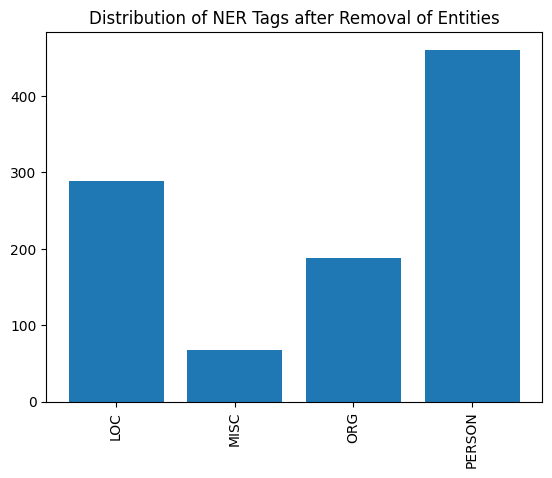

In [65]:
# Count of Labels for Test Set

labels4 = {}
for i in test[1]:
    for j in i:
        labels4[j['label']] = labels4.get(j['label'], 0) + 1

labels4 = dict(sorted(labels4.items(), key=lambda item: item[0]))
plt.bar(labels4.keys(), labels4.values())
plt.xticks(rotation = 90)
plt.title("Distribution of NER Tags after Removal of Entities")
plt.show()

In [66]:
true1 = []
for i in test[1]:
  temp = []
  for j in i:
    temp.append([j['start'], j['end'], j['label']])
  true1.append(temp)

In [67]:
def empty_dict(l):
    di = {}
    for i in l:
        di[i] = 0
    return di

In [68]:
# Perfect Match
# Partial Match
# Hallucination - Insertion
# Omission - Deletion
# Substitution

perf_match = empty_dict(list(label_list))
part_match = empty_dict(list(label_list))
insert = empty_dict(list(label_list))
delete = empty_dict(list(label_list))
sub = empty_dict(list(label_list))

true = copy.deepcopy(true1)
pred1 = copy.deepcopy(final_pred)

for i in range(len(true)):
    for j in true[i]:
        if j in pred1[i]:
            perf_match[j[2]] = perf_match.get(j[2], 0) + 1
            print(j, "---", pred1[i], " -- Perfect Match")
            pred1[i].remove(j)

        else:
            start = j[0]
            end = j[1]
            tag = j[2]
            flag = False
            for k in pred1[i][::-1]:
                if start == k[0]:
                    flag = True
                    if tag == k[-1]:
                        part_match[j[2]] = part_match.get(j[2], 0) + 1
                        print(j, "---", k, " -- Partial Match")
                        pred1[i].remove(k)

                    elif tag != k[-1]:
                        sub[j[2]] = sub.get(j[2], 0) + 1
                        print(j, "---", k, " -- Substitution")
                        pred1[i].remove(k)

            if flag == False:
                print(j, " -- Omission")
                delete[j[2]] = delete.get(j[2], 0) + 1

    if len(pred1[i]) != 0:
        for k in pred1[i]:
            print( k, " -- Hallucination")
            insert[k[-1]] = insert.get(k[-1], 0) + 1


[9, 14, 'LOC'] --- [[9, 14, 'LOC'], [31, 36, 'LOC']]  -- Perfect Match
[31, 36, 'PERSON'] --- [31, 36, 'LOC']  -- Substitution
[0, 11, 'PERSON'] --- [[0, 11, 'PERSON']]  -- Perfect Match
[0, 6, 'LOC'] --- [[0, 6, 'LOC'], [9, 29, 'LOC']]  -- Perfect Match
[9, 29, 'LOC'] --- [[9, 29, 'LOC']]  -- Perfect Match
[0, 5, 'LOC'] --- [[0, 5, 'LOC'], [33, 42, 'MISC'], [78, 83, 'LOC']]  -- Perfect Match
[33, 42, 'MISC'] --- [[33, 42, 'MISC'], [78, 83, 'LOC']]  -- Perfect Match
[78, 83, 'LOC'] --- [[78, 83, 'LOC']]  -- Perfect Match
[4, 9, 'LOC'] --- [[4, 9, 'LOC'], [119, 129, 'LOC']]  -- Perfect Match
[119, 129, 'LOC'] --- [[119, 129, 'LOC']]  -- Perfect Match
[0, 5, 'LOC'] --- [[0, 5, 'LOC'], [93, 98, 'MISC'], [107, 120, 'PERSON'], [205, 212, 'MISC']]  -- Perfect Match
[93, 98, 'MISC'] --- [[93, 98, 'MISC'], [107, 120, 'PERSON'], [205, 212, 'MISC']]  -- Perfect Match
[107, 120, 'PERSON'] --- [[107, 120, 'PERSON'], [205, 212, 'MISC']]  -- Perfect Match
[205, 212, 'MISC'] --- [[205, 212, 'MISC']] 

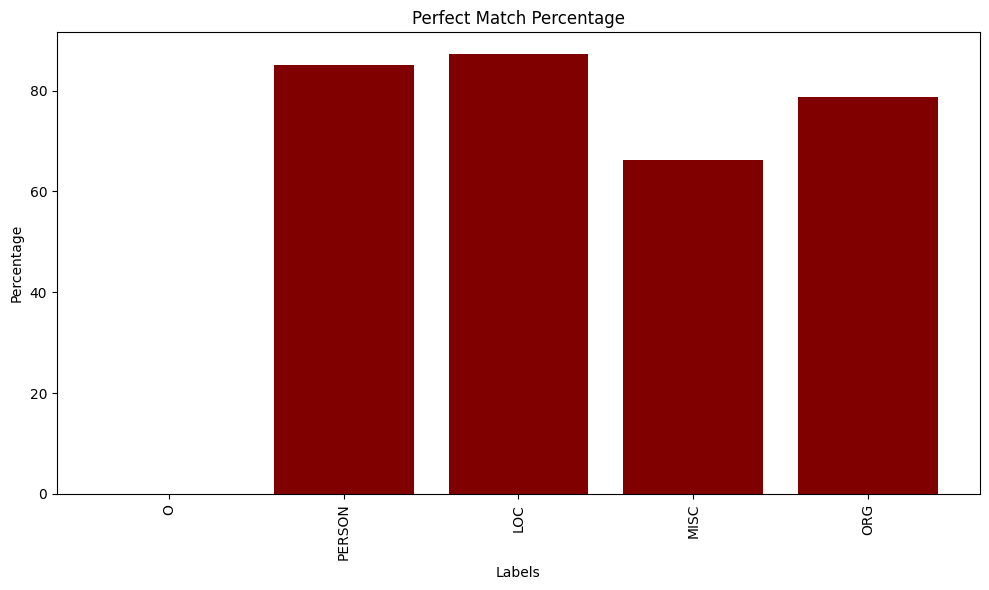

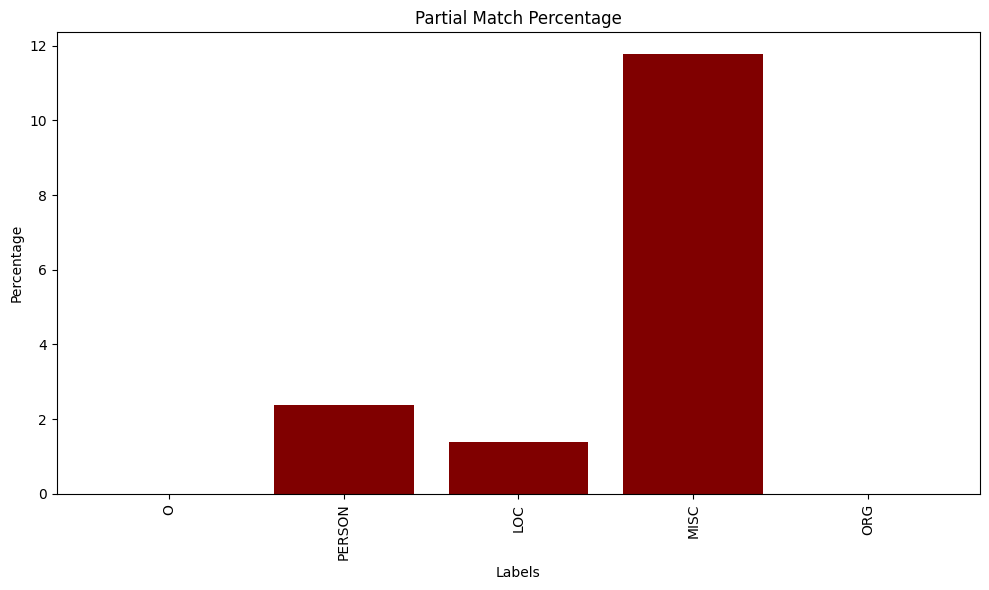

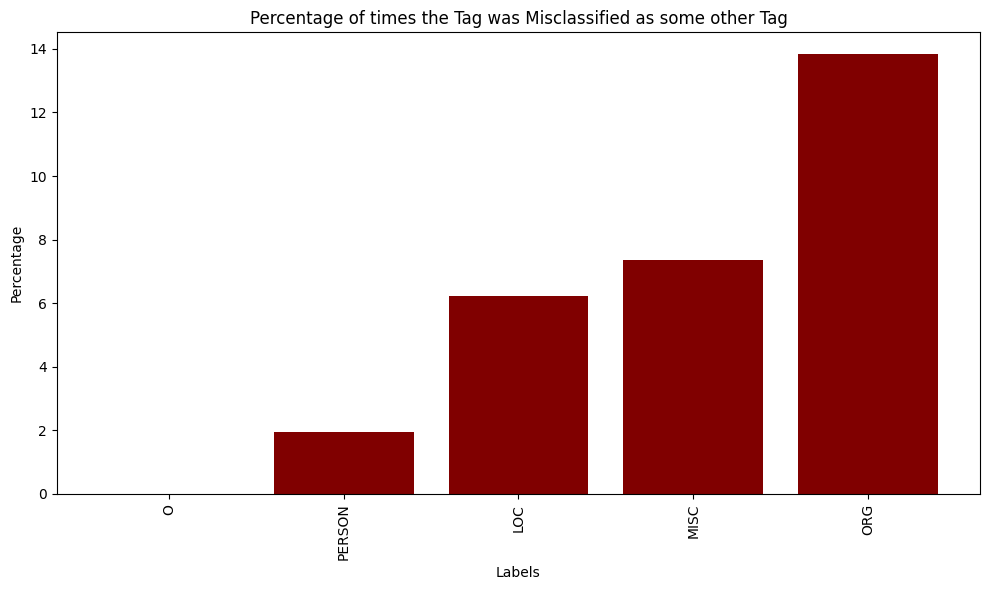

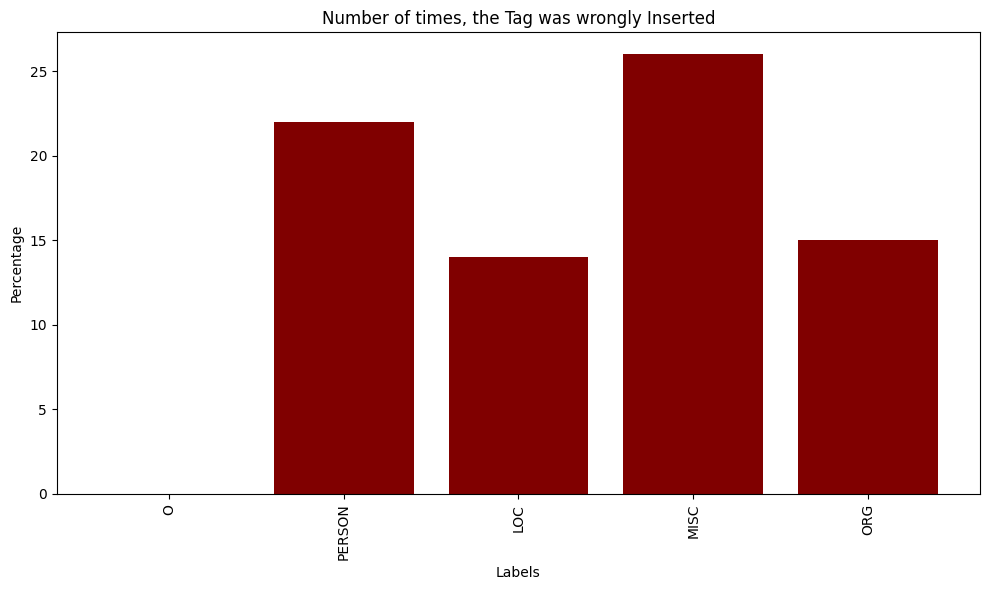

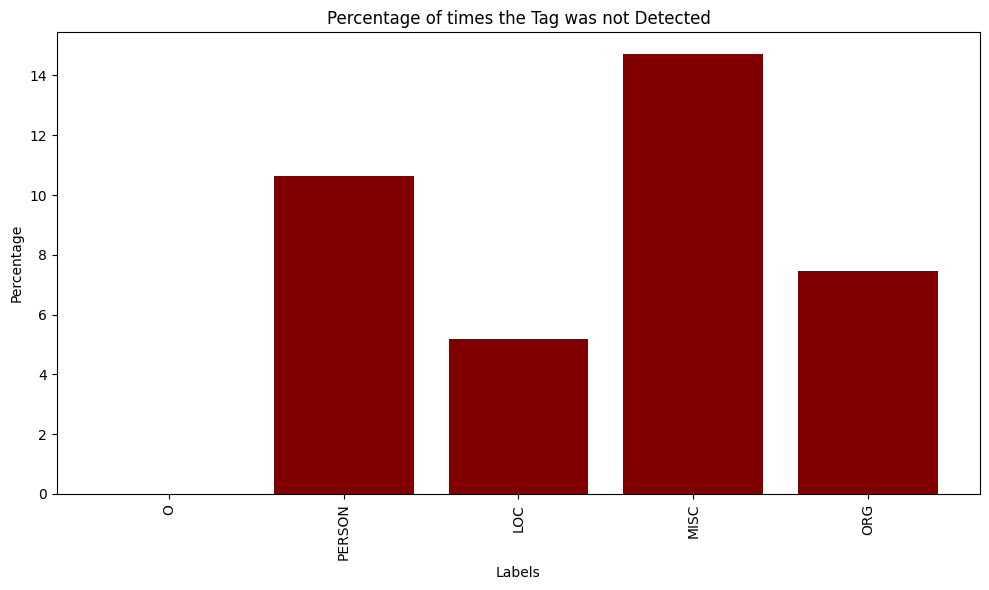

In [69]:
perfect = []
part = []
substituted = []
hallucinated = []
omitted = []

for i in list(label_list):
    try:
        num = labels4[i]
        perfect.append((perf_match[i]/num)*100)
        part.append((part_match[i]/num)*100)
        substituted.append((sub[i]/num)*100)
        hallucinated.append(insert[i])
        omitted.append((delete[i]/num)*100)

    except:
        perfect.append(0)
        part.append(0)
        substituted.append(0)
        hallucinated.append(0)
        omitted.append(0)

lists = [perfect, part, substituted, hallucinated, omitted]
list_names = ["Perfect Match Percentage", "Partial Match Percentage", "Percentage of times the Tag was Misclassified as some other Tag", "Number of times, the Tag was wrongly Inserted", "Percentage of times the Tag was not Detected"]

for i, data in enumerate(lists):
    plt.figure(figsize=(10, 6))
    plt.bar(label_list, data, color='maroon')
    plt.xlabel('Labels')
    plt.ylabel('Percentage')
    plt.title(list_names[i])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [70]:
import pandas as pd

data = {
    'Tag': list(label_list),
    'Perfect (%)': perfect,
    'Part (%)': part,
    'Substituted (%)': substituted,
    'Hallucinated': hallucinated,
    'Omitted (%)': omitted
}

df = pd.DataFrame(data)
df

,Tag,Perfect (%),Part (%),Substituted (%),Hallucinated,Omitted (%)
0,O,0.000000,0.000000,0.000000,0,0.000000
1,PERSON,85.032538,2.386117,1.952278,22,10.629067
2,LOC,87.197232,1.384083,6.228374,14,5.190311
3,MISC,66.176471,11.764706,7.352941,26,14.705882
4,ORG,78.723404,0.000000,13.829787,15,7.446809


In [1]:
import pandas as pd

data = {
    'Tag': ['O', 'PERSON', 'LOC', 'MISC', 'ORG'],
    'Perfect (%)': [0.000000, 85.032538, 87.197232, 66.176471, 78.723404],
    'Part (%)': [0.000000, 2.386117, 1.384083, 11.764706, 0.000000],
    'Substituted (%)': [0.000000, 1.952278, 6.228374, 7.352941, 13.829787],
    'Hallucinated': [0, 22, 14, 26, 15],
    'Omitted (%)': [0.000000, 10.629067, 5.190311, 14.705882, 7.446809]
}

df = pd.DataFrame(data)

avg_row = df.iloc[1:].mean()
avg_row['Tag'] = 'Average'

df = df.append(avg_row, ignore_index=True)

df



/var/folders/yl/5879yj014q11kbqcnjh_rd0m0000gn/T/ipykernel_7241/3599474201.py:14: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_row = df.iloc[1:].mean()
/var/folders/yl/5879yj014q11kbqcnjh_rd0m0000gn/T/ipykernel_7241/3599474201.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(avg_row, ignore_index=True)


,Tag,Perfect (%),Part (%),Substituted (%),Hallucinated,Omitted (%)
0,O,0.000000,0.000000,0.000000,0.00,0.000000
1,PERSON,85.032538,2.386117,1.952278,22.00,10.629067
2,LOC,87.197232,1.384083,6.228374,14.00,5.190311
3,MISC,66.176471,11.764706,7.352941,26.00,14.705882
4,ORG,78.723404,0.000000,13.829787,15.00,7.446809
5,Average,79.282411,3.883726,7.340845,19.25,9.493017
